In [41]:
#pip install notebook ipywidgets

# Global Land Temperature Analysis - Time Series Analysis & Forecasting
In this notebook we will be investigating a dataset of global temperatures taken in major cities every month from late 1800s to 2013. This investigation will involve cleaning and formating the data, decomposing and visualization, as well as forecasting. The goal of thise investigation will be to use time series analysis to better understand trends presented in the data as well as use forecasting to see if we can potentaially predict temperature data. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Import and clean the data

In [42]:
global_temp = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
global_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [44]:
global_temp.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

Important data to note:

dt: date of temperature recording <-change to datetime and set as index

AverageTemperature: in celcius <-is in celcius, will change to fahrenheit for better understanding from American perspective

In [45]:
global_temp.isnull().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [46]:
global_temp[global_temp["AverageTemperature"].isnull()]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
36,1852-01-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
37,1852-02-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
38,1852-03-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
39,1852-04-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
40,1852-05-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
237089,1839-10-01,NaN,NaN,Xian,China,34.56N,108.97E
237090,1839-11-01,NaN,NaN,Xian,China,34.56N,108.97E
237091,1839-12-01,NaN,NaN,Xian,China,34.56N,108.97E
237422,1867-07-01,NaN,NaN,Xian,China,34.56N,108.97E


In [47]:
global_temp.groupby(['City']).count()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude
City,,,,,,
Abidjan,1977,1777,1777,1977,1977,1977
Addis Abeba,1965,1679,1679,1965,1965,1965
Ahmadabad,2613,2448,2448,2613,2613,2613
Aleppo,2669,2479,2479,2669,2669,2669
Alexandria,2669,2666,2666,2669,2669,2669
...,...,...,...,...,...,...
Tokyo,2025,2020,2020,2025,2025,2025
Toronto,3239,3141,3141,3239,3239,3239
Umm Durman,1857,1768,1768,1857,1857,1857


There are several null data points, but if we look at the count for each city, removing the nulls would still leave us with at least 1000+ data points to investigate, so drop null rows

In [48]:
global_temp = global_temp.dropna(how='any',axis=0)
global_temp.groupby(['City']).count()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude
City,,,,,,
Abidjan,1777,1777,1777,1777,1777,1777
Addis Abeba,1679,1679,1679,1679,1679,1679
Ahmadabad,2448,2448,2448,2448,2448,2448
Aleppo,2479,2479,2479,2479,2479,2479
Alexandria,2666,2666,2666,2666,2666,2666
...,...,...,...,...,...,...
Tokyo,2020,2020,2020,2020,2020,2020
Toronto,3141,3141,3141,3141,3141,3141
Umm Durman,1768,1768,1768,1768,1768,1768


Convert dt column to datetime type and set as index

In [49]:
global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp.set_index('dt',inplace=True)
global_temp.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


Convert AverageTemperature to fharenheit

In [50]:
global_temp['AverageTemperature'] = global_temp.apply(lambda x: (9/5)*x['AverageTemperature']+32,axis=1)
global_temp.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1849-01-01,80.0672,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,81.3812,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,82.5818,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,79.0520,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,77.7686,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [51]:
global_temp['Year']=global_temp.index.year
global_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,Year
count,228175.000000,228175.000000,228175.000000
mean,64.626744,0.969343,1913.893209
std,18.044639,0.979644,62.025981
min,-16.189600,0.040000,1743.000000
25%,54.878000,0.340000,1869.000000
50%,68.770400,0.592000,1918.000000
75%,78.652400,1.320000,1966.000000
max,100.909400,14.037000,2013.000000


# Initial analysis and visualization

Data ranging from 1743-2013, want to look at latest, assumabily most accurate data, cut to 1960

In [53]:
recent_temp = global_temp.loc['1960':]
recent_temp.groupby(['City']).count()

,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude,Year
City,,,,,,
Abidjan,644,644,644,644,644,644
Addis Abeba,644,644,644,644,644,644
Ahmadabad,644,644,644,644,644,644
Aleppo,644,644,644,644,644,644
Alexandria,644,644,644,644,644,644
...,...,...,...,...,...,...
Tokyo,644,644,644,644,644,644
Toronto,645,645,645,645,645,645
Umm Durman,644,644,644,644,644,644


This leaves us with about the same number of rows for each major city, meaning they should all have data points for the most recent years

Now, combine the city and country columns for presentation

In [54]:
recent_temp['CityCountry']=recent_temp['City']+", "+recent_temp['Country']
recent_temp.drop(columns=['City','Country'],inplace = True)
recent_temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Year,CityCountry
dt,,,,,,
1960-01-01,80.2670,0.395,5.63N,3.23W,1960,"Abidjan, Côte D'Ivoire"
1960-02-01,82.8320,0.249,5.63N,3.23W,1960,"Abidjan, Côte D'Ivoire"
1960-03-01,81.9752,0.211,5.63N,3.23W,1960,"Abidjan, Côte D'Ivoire"
1960-04-01,80.7026,0.162,5.63N,3.23W,1960,"Abidjan, Côte D'Ivoire"
1960-05-01,80.6054,0.274,5.63N,3.23W,1960,"Abidjan, Côte D'Ivoire"


Group the recent data and find the average of all average temperatures, so finding what the average temperature was for 1960-2013, and graph

In [56]:
recent_temp[['CityCountry','AverageTemperature']].groupby(['CityCountry']).mean().sort_values('AverageTemperature')

,AverageTemperature
CityCountry,
"Harbin, China",39.938620
"Saint Petersburg, Russia",40.304526
"Moscow, Russia",40.695806
"Montreal, Canada",41.560514
"Changchun, China",42.250008
...,...
"Ho Chi Minh City, Vietnam",81.790918
"Bangkok, Thailand",81.804661
"Jiddah, Saudi Arabia",82.543312


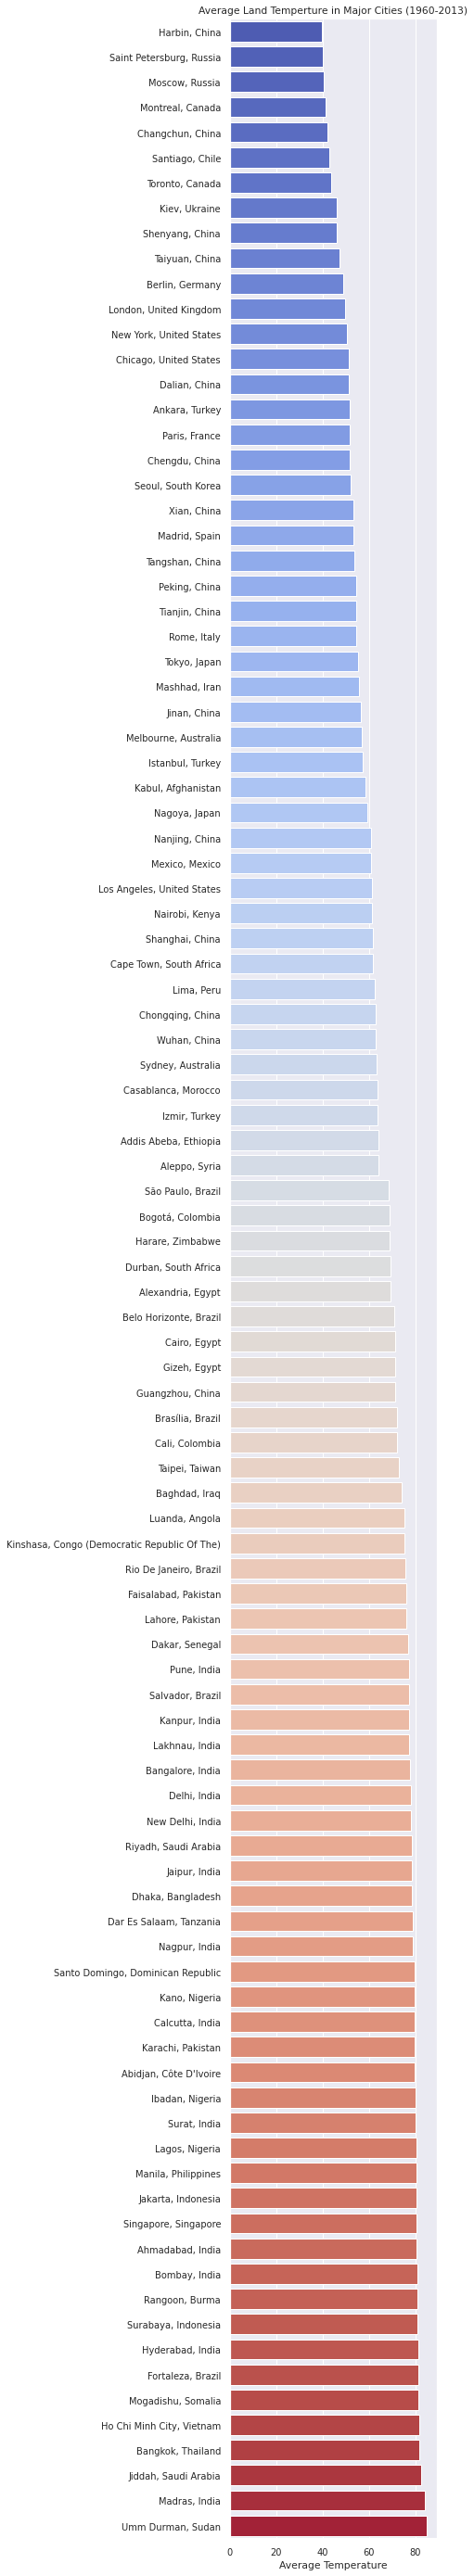

In [71]:
cities = np.unique(recent_temp['CityCountry'])
avg_temp = []
for c in cities:
    avg_temp.append(recent_temp[recent_temp['CityCountry']==c]['AverageTemperature'].mean())
avg_temp_g, bar_g = (list(x) for x in zip(*sorted(zip(avg_temp,cities))))
sns.set(font_scale=0.9)
f, ax = plt.subplots(figsize=(4,50))
colors_cw=sns.color_palette('coolwarm',len(cities))
sns.barplot(avg_temp_g,bar_g,palette=colors_cw[::1])
Text =ax.set(xlabel='Average Temperature', title='Average Land Temperture in Major Cities (1960-2013)')

From this graph we can see the major cities organized by coolest to warmest average temperature with Harbin, China being coldest and Umm Durman, Sudan as the warmest

Now, we will resample the data so the AverageTemperature will now referance the annual average rather than monthly and will average all temperatures globally

In [58]:
resample_recent = recent_temp[['AverageTemperature']].resample('A').mean()
resample_recent.tail()

,AverageTemperature
dt,
2009-12-31,67.700753
2010-12-31,67.841121
2011-12-31,67.188554
2012-12-31,67.402831
2013-12-31,68.473411


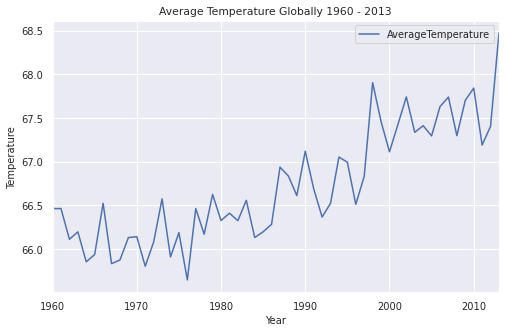

In [59]:
resample_recent.plot(title="Average Temperature Globally 1960 - 2013",figsize=(8,5))
plt.xlabel('Year',fontsize = 10)
plt.ylabel('Temperature', fontsize= 10)
plt.legend()

# Moving into time teries analysis
Time series data is that which is recorded on a consistent time interval, such as our data. This sort of data is able to be broken down, or decomposed, into different catagories which include: trend (a general up or down pattern overall), seasonality ( a repeated pattern over certain time intervals), and noise or residual (what ever is left over, does not contribute to patterns)

In the eyes of timeseries, this plot has trend, possible seasonality, and randomness so could be decomposed additivly

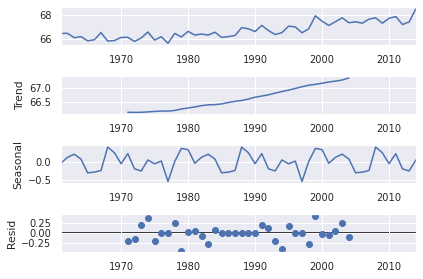

In [60]:
decomp = seasonal_decompose(resample_recent, model='additive',period=20)
decomp.plot()
plt.show()

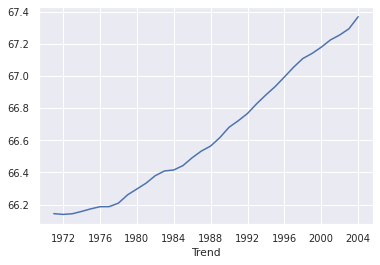

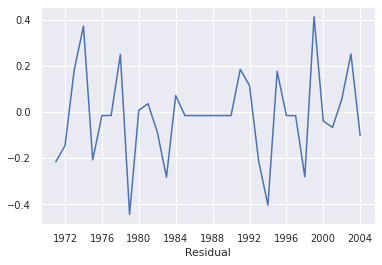

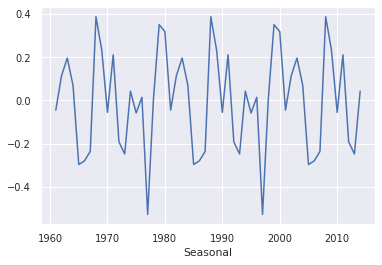

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(decomp.trend)
plt.xlabel('Trend')
plt.figure()

plt.plot(decomp.resid)
plt.xlabel('Residual')
plt.figure()

plt.plot(decomp.seasonal)
plt.xlabel('Seasonal')
plt.figure()

plt.tight_layout()

After plotting the decomposition it does not seem as though there is a true steady seasonality, however we can see a steady upwards trend to the global temperature

# Forecasting
Now, we will split the data into training and testing to begin forecasting

In [61]:
train = resample_recent[resample_recent.index <= pd.to_datetime("1996-12-31")]
train.describe()

,AverageTemperature
count,37.000000
mean,66.345286
std,0.366979
min,65.643500
25%,66.128609
50%,66.323374
75%,66.555631
max,67.117188


In [62]:
test = resample_recent[resample_recent.index > pd.to_datetime("1996-12-31")]
test.describe()

,AverageTemperature
count,17.000000
mean,67.516016
std,0.373069
min,66.830292
25%,67.295801
50%,67.422833
75%,67.737686
max,68.473411


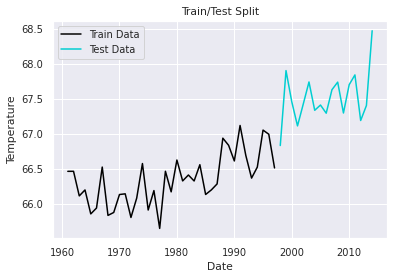

In [64]:
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "darkturquoise", label = 'Test Data')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Train/Test Split")
plt.legend()
plt.show()

We will be using the ARIMA function on the training data to produce the predidctions. ARIMA is an auto regressive model that uses the previous data points and patterns to produce the future values. 

I decided to use the ARIMA model as there is no strong seasonality so SARIM would not be fitting, but it also allows for more adjusting of parameteres compared to ARMA. 

The ARIMA parameters are described by builtin.com as: "The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events)"

Will begin with the low parameters of 2,2,2 to get initial insight. 

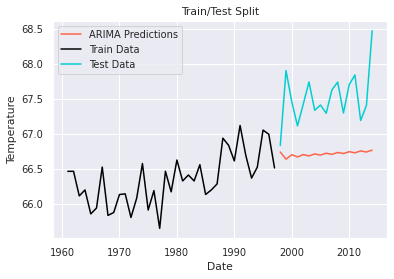

In [65]:
arima_model = ARIMA(train['AverageTemperature'],order = (2,2,2))
arima_model = arima_model.fit()

pred = arima_model.get_forecast(len(test.index))
pred_df = pred.conf_int(alpha = 0.05) 
pred_df["Predictions"] = arima_model.predict(start = pred_df.index[0], end = pred_df.index[-1])
pred_df.index = test.index
pred_out = pred_df["Predictions"] 
plt.plot(pred_out, color='tomato', label = 'ARIMA Predictions')
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "darkturquoise", label = 'Test Data')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Train/Test Split")
plt.legend()
plt.show()


To better determine the ARIMA parameters, we can plot the autocorrelation and partical ac functions. This will demonstrate how the values relate to each other and help to determine what the first parameter should be. We will use the first difference of the training data to plot them. 

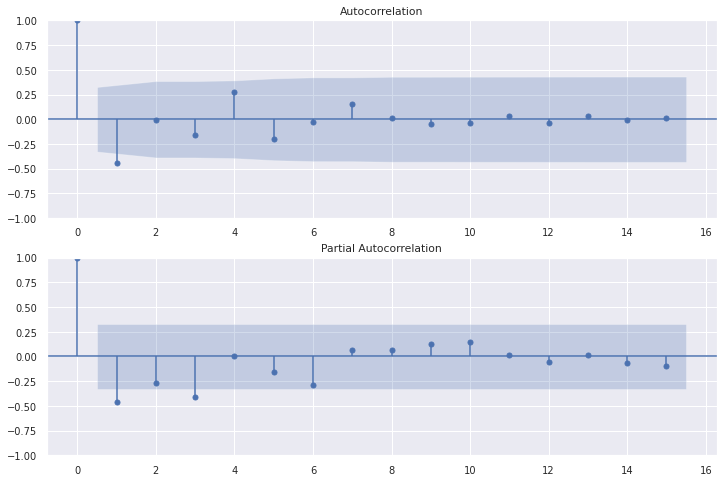

In [66]:
first_diff = train.AverageTemperature - train.AverageTemperature.shift(1)
first_diff = first_diff.dropna(inplace = False)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=15, ax=ax2)

Since around 6 is where the pcf flips from negative to mostly positive, this is the value we will choose for the first parameter. The second value we will increase only by one to incease stability, and the final value we will also increase to 6 we could tell from the residual decomposition plot that there is a large amount of noise in the data. 

Now, running with the new parameters:

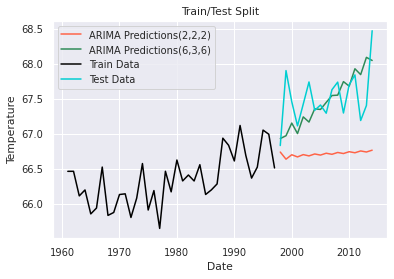

In [69]:
arima_model2 = ARIMA(train['AverageTemperature'],order = (6,3,6))
arima_model2 = arima_model2.fit()

pred2 = arima_model2.get_forecast(len(test.index))
pred2_df = pred2.conf_int(alpha = 0.05) 
pred2_df["Predictions"] = arima_model2.predict(start = pred2_df.index[0], end = pred2_df.index[-1])
pred2_df.index = test.index
pred2_out = pred2_df["Predictions"] 
plt.plot(pred_out, color='tomato', label = 'ARIMA Predictions(2,2,2)')
plt.plot(pred2_out, color='seagreen', label = 'ARIMA Predictions(6,3,6)')
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "darkturquoise", label = 'Test Data')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Train/Test Split")
plt.legend()
plt.show()

In the graph above we can see the final run of the ARIMA model. Our predictions in green match the trend of the test data very well. It has some noise variation to it, but not quite as much as the actual test data, so that is an area in which the model can be improved on. 